In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

# 1D Bar Solution

In [2]:
bc = 1  # constrain (or Boundary condition) at node 1
E = 70000   # Youngs Modulus
A = 300*40   # Cross Section Area
L = 1500  # Length of Bar
F = 4000   # Force at the tip of Bar
numElem = 4  # Number of Elements

In [3]:
le = L/numElem

elem = []
for i in range(numElem):
    elem.append([i+1,i+2])
elem

[[1, 2], [2, 3], [3, 4], [4, 5]]

In [4]:
x = Symbol('x')
Le = Symbol('Le')

# Shape Function Matrix
shape = [
    (1-x/Le),
    (x/Le)
]

# Differentiated Shape Function Matrix
shape_d = []
for i in shape:
    shape_d.append(diff(i, x))

shape = np.matrix(shape)
shape_d = np.matrix(shape_d)

shape, shape_d

(matrix([[1 - x/Le, x/Le]], dtype=object),
 matrix([[-1/Le, 1/Le]], dtype=object))

In [5]:
# Creating The Local Stiffness Matrix

k = np.matmul(shape_d.T, shape_d)
for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        k[i,j] = simplify(integrate(k[i,j], x).subs(x, Le))
k

matrix([[1/Le, -1/Le],
        [-1/Le, 1/Le]], dtype=object)

In [6]:
K = np.zeros([len(elem)+1, len(elem)+1])  # Creating initially zero matrix for global stiffness matrix

for i in elem:
    temp = k.copy()
    for a in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            temp[a,j] = temp[a,j].subs(Le, le)
    K[i[0]-1:i[1], i[0]-1:i[1]] = K[i[0]-1:i[1], i[0]-1:i[1]] + (E*A) * temp

array([[ 2552819.20991769, -2552819.20991769,        0.        ,
               0.        ,        0.        ],
       [-2552819.20991769,  5105638.41983538, -2552819.20991769,
               0.        ,        0.        ],
       [       0.        , -2552819.20991769,  5105638.41983538,
        -2552819.20991769,        0.        ],
       [       0.        ,        0.        , -2552819.20991769,
         5105638.41983538, -2552819.20991769],
       [       0.        ,        0.        ,        0.        ,
        -2552819.20991769,  2552819.20991769]])

In [7]:
# Function to apply Boundary Conditions
def BC(K, bc):
    newK = []
    for i in range(len(K)):
        temp = []
        for j in range(len(K[0])):
            if not(i==bc or j==bc):
                temp.append(K[i][j])
        if temp != []:
            newK.append(temp)
    return np.matrix(newK)

In [8]:
# Global Stiffness Matrix After Applying Boundary Conditions
Kc = BC(K, bc-1)

matrix([[ 5105638.41983538, -2552819.20991769,        0.        ,
                0.        ],
        [-2552819.20991769,  5105638.41983538, -2552819.20991769,
                0.        ],
        [       0.        , -2552819.20991769,  5105638.41983538,
         -2552819.20991769],
        [       0.        ,        0.        , -2552819.20991769,
          2552819.20991769]])

In [9]:
# Creating Force Vector
f = np.zeros([len(Kc), 1])
f[-1] = F

array([[   0.],
       [   0.],
       [   0.],
       [3955.]])

In [10]:
# Obtaining the Nodal Displacement Vector
u = np.linalg.solve(Kc, f)
u = list(u)
u.insert(0, [0])
u = np.matrix(u)
u

matrix([[0.        ],
        [0.00154927],
        [0.00309854],
        [0.0046478 ],
        [0.00619707]])

In [11]:
# Obtaining the Full force Vector including the Reaction Force
Force = np.matmul(K, u)
Force

matrix([[-3.95500000e+03],
        [ 0.00000000e+00],
        [-1.36424205e-12],
        [ 0.00000000e+00],
        [ 3.95500000e+03]])

In [12]:
# Calculation the Strains using the nodal displacement vector
strain = []
for i in elem:
    temp = []
    for a in range(shape_d.size):
        temp.append(shape_d[0,a].subs(Le, le))
    temp = np.matrix(temp)   
    strain.append(np.matmul(temp, u[i[0]-1:i[1], 0]))
strain

[matrix([[4.12314762062802e-6]], dtype=object),
 matrix([[4.12314762062802e-6]], dtype=object),
 matrix([[4.12314762062802e-6]], dtype=object),
 matrix([[4.12314762062802e-6]], dtype=object)]

In [13]:
# Calculation Stress
stress = E * np.array(strain)
stress

array([[[0.292809451426520]],

       [[0.292809451426520]],

       [[0.292809451426520]],

       [[0.292809451426520]]], dtype=object)

In [14]:
u_act = F*L/(E*A)

print('Hand Caluclation:', u_act)
print('FEM:', u[-1,0])
print('% Error:', (u_act-u[-1,0])*100/u_act)

Hand Caluclation: 0.006197070258065817
FEM: 0.006197070258065817
% Error: 0.0


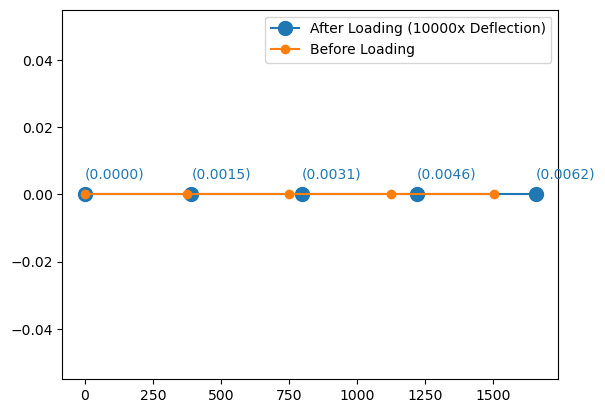

In [15]:
Multiplier = 1*10**4
x = [[0]]
te = 0
for i in range(len(u)-1):
    te = te + le
    x.append([te])
x = np.matrix(x)

y = [[0]]
te = 0
for i in range(len(u)-1):
    te = te + le + u[i+1,0]*Multiplier
    y.append([te])
y = np.matrix(y)


plt.plot(y, np.zeros([y.size,1]), marker='o', color='tab:blue', markersize=10, label=f'After Loading ({Multiplier}x Deflection)')
ind = 0
for i in zip(y,np.zeros([y.size,1])):
    plt.annotate('(%.4f)'% (u[ind,0]), xy=i, xytext=(y[ind],0.005), color='tab:blue')
    ind = ind+1

plt.plot(x, np.zeros([x.size,1]), marker='o', color='tab:orange', label='Before Loading')
plt.legend()